# Machine Learning with Titanic - Sample Solution

Here is a solution for the popular "Machine Learning with Titanic Data" challenge from Kaggle

### Setup the imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from matplotlib import pyplot as plt

### Read in the data

In [2]:
df = pd.read_csv('train.csv',  index_col=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Basic EDA

<AxesSubplot: ylabel='PassengerId'>

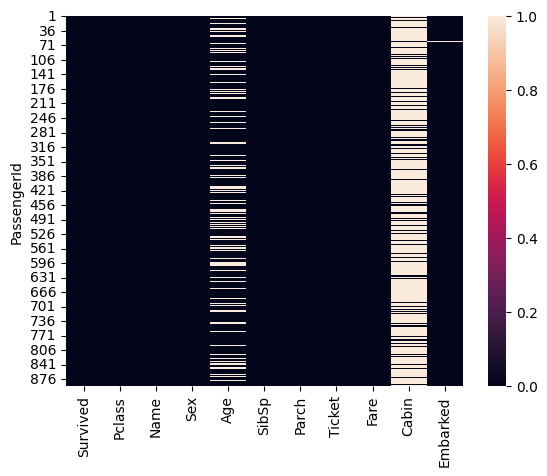

In [3]:
# missing info
sns.heatmap(df.isna())

### Prepare the X and y data

In [4]:
y = df['Survived']
X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']]

### Train test split X and y data

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

### Feature Engineering

In [6]:
def feature_engineering(X, agemean):
    """adds extra features to a DataFrame"""
    X['Age'].fillna(agemean, inplace=True)
    # one-hot encoding
    X['female'] = (X['Sex']=='female').astype(int)
    X['child'] = (X['Age'] < 14).astype(int)
    # interaction terms
    X['female_pclass'] = X['female']       * X['Pclass']
    X['male_pclass']   = (1 - X['female']) * X['Pclass']
    X['child_pclass']  = X['child']        * X['Pclass']
    X['adult_pclass']  = (1 - X['child'])  * X['Pclass']
    del X['Sex']

In [7]:
Xtrain = Xtrain.copy()
Xtest = Xtest.copy()

In [8]:
agemeans = df.groupby(['Pclass','Sex'])['Age'].mean()

agemean = Xtrain['Age'].mean()
feature_engineering(Xtrain, agemean)
feature_engineering(Xtest, agemean)  # use training mean to avoid 'data leakage' in .mean()

In [9]:
Xtrain.shape, ytrain.shape

((668, 10), (668,))

In [10]:
Xtest.shape, ytest.shape

((223, 10), (223,))

### LogReg Model

In [11]:
m = LogisticRegression(max_iter=1000)

### Cross validate the model and intepret the results

In [12]:
cv_all = cross_val_score(m, Xtrain, ytrain, cv=10, scoring='accuracy')
cv_mean = cv_all.mean()
cv_std = np.std(cv_all)
f"Cross-validation mean {cv_mean:5.3f} +- {cv_std:5.3f}"

'Cross-validation mean 0.801 +- 0.041'

In [13]:
m.fit(Xtrain, ytrain)
train_score = m.score(Xtrain, ytrain)
train_score.round(3)

0.807

In [14]:
test_score = m.score(Xtest, ytest)
test_score.round(3)

0.789

### Evaluate the models predictive power

In [15]:
ypred = m.predict(Xtest)

In [16]:
#normalise the confusion matrix - its easier to interpret
norm_cm = (confusion_matrix(ytest, ypred) / confusion_matrix(ytest, ypred).sum()) * 100
norm_cm = norm_cm.round(2)

<AxesSubplot: >

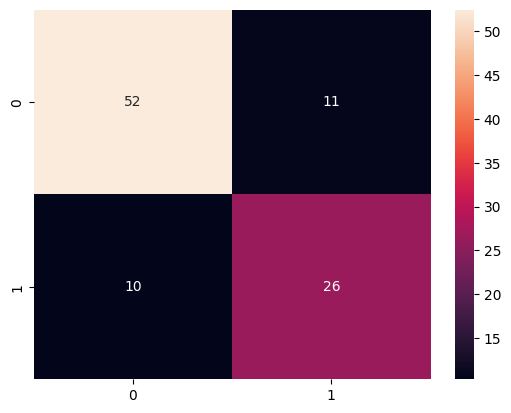

In [17]:
# Confusion matrix
sns.heatmap(norm_cm, annot=True)

Text(0.5, 1.0, 'roc curve')

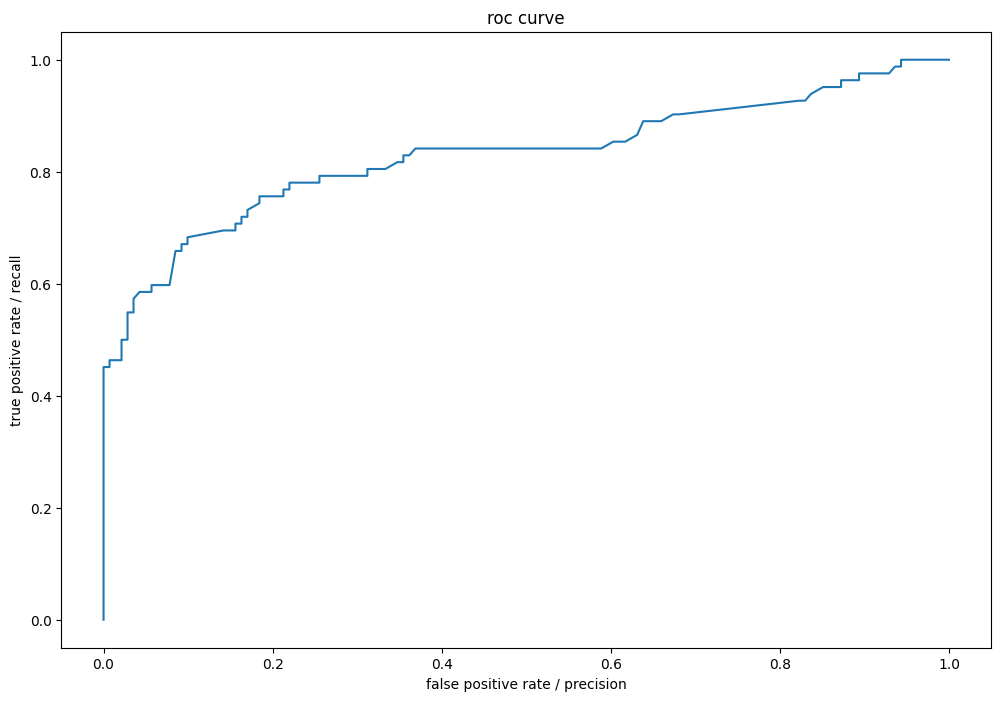

In [18]:
# roc curve
ypred_proba = m.predict_proba(Xtest)[:,1]
fpr, tpr, threshold = roc_curve(ytest, ypred_proba)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr)
plt.xlabel('false positive rate / precision')
plt.ylabel('true positive rate / recall')
plt.title('roc curve')

### Examine the strength of the coefficients for each feature

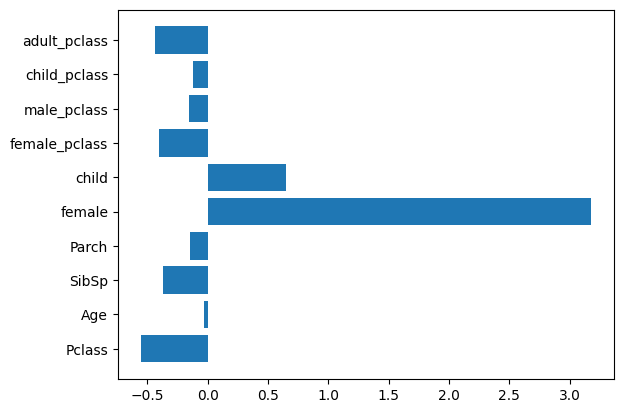

In [19]:
plt.barh(range(10), m.coef_[0])
plt.yticks(range(10), Xtrain.columns)
None

### Random Forest Model

In [23]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators=20, max_depth=2)
cross_val_score(m, Xtrain, ytrain, cv=5, scoring='accuracy')

array([0.76865672, 0.70895522, 0.75373134, 0.85714286, 0.81954887])

In [24]:
m.fit(Xtrain, ytrain)
m.score(Xtrain, ytrain)

0.7859281437125748

In [25]:
m.score(Xtest, ytest)

0.820627802690583

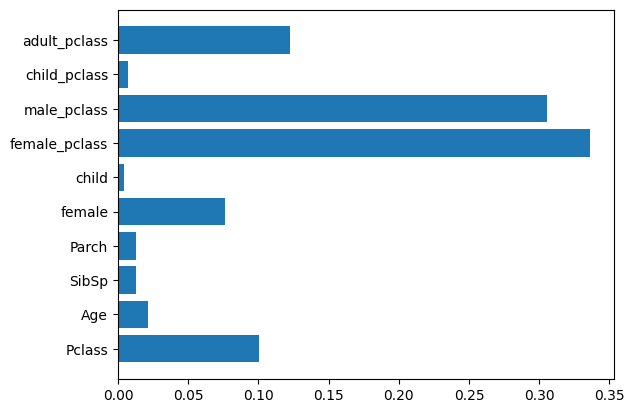

In [26]:
plt.barh(range(10), m.feature_importances_)
plt.yticks(range(10), Xtrain.columns)
None